In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from markowitz import Data, Parameters, markowitz
from experiments.utils import synthetic_returns
from experiments.backtest import interest_and_fees, OptimizationInput, create_orders, execute_orders, Timing, BacktestResult, run_markowitz

from tuning import HyperParameters, get_data_and_parameters, full_markowitz

# autoreload modules
%load_ext autoreload
%autoreload 2

In [128]:
steps = 750

prices = pd.read_csv("../data/prices.csv", index_col=0, parse_dates=True).iloc[:]
spread = pd.read_csv("../data/spreads.csv", index_col=0, parse_dates=True).iloc[:]
volume = pd.read_csv("../data/volumes.csv", index_col=0, parse_dates=True).iloc[:]
rf = pd.read_csv("../data/rf.csv", index_col=0, parse_dates=True).iloc[:, 0].iloc[:]
# returns = prices.pct_change().dropna()

train_len = 1250
test_len = 500

# -500 since first 500 re discarded in backtest
prices_train = prices.iloc[-train_len-test_len-500:-test_len]
prices_test = prices.iloc[-test_len-500:]
spread_train = spread.iloc[-train_len-test_len-500:-test_len]
spread_test = spread.iloc[-test_len-500:]
volume_train = volume.iloc[-train_len-test_len-500:-test_len]
volume_test = volume.iloc[-test_len-500:]
rf_train = rf.iloc[-train_len-test_len-500:-test_len]
rf_test = rf.iloc[-test_len-500:]

returns_train = prices_train.pct_change().dropna()
returns_test = prices_test.pct_change().dropna()

n_assets = prices.shape[1]

In [361]:
# full_markowitz(inputs, hyperparamters, initialize=False, hard=True)

prices_t = prices_train.iloc[:steps]
spread_t = spread_train.iloc[:steps]
volume_t = volume_train.iloc[:steps]
rf_t = rf_train.iloc[steps]
returns_t = returns_train.iloc[:steps]
covariance_t = returns_t.cov()
mean_t = returns_t.mean()

prices_0 = prices_t.iloc[-1]
quantities = np.zeros(n_assets) * (1 / prices_0) / np.sum(1 / prices_0) * 1e6
cash = 1e6

inputs_t = OptimizationInput(
            prices_t,
            mean_t,
            covariance_t,
            spread_t,
            volume_t,
            quantities,
            cash,
            0.1/np.sqrt(252),
            rf.iloc[steps],
        )



In [324]:
from collections import namedtuple
from dataclasses import dataclass
@dataclass
class HyperParameters:
    gamma_hold: float
    gamma_trade: float
    gamma_turn: float
    gamma_leverage: float
    gamma_risk: float

def tune_parameters(
    strategy,
    prices,
    spread,
    volume,
    rf,
    risk_target,
):  
    def run_strategy(hyperparameters, hard):
        results, duals = run_markowitz(
            strategy,
            prices,
            spread,
            volume,
            rf,
            risk_target,
            hyperparameters,
            hard=hard,
            verbose=False,
        )
        return results, duals

    # gamma_hold, gamma_trade, gamma_turn, gamma_leverage, gamma_risk
    # hyperparameters = HyperParameters(
    #     0, 0, 0, 0, 0
    #     )
    # # First find reasonable soft constraing parameters

    # if verbose:
    #     print("Tuning soft constraint parameters")
    # results, duals = run_strategy(hyperparameters, hard=True)
    # gamma_risk = duals.Risk.quantile(0.95)
    # gamma_turn = duals.Turnover.quantile(0.95)
    # gamma_leverage = duals.Leverage.quantile(0.95)

    # # tune gamma_hold and gamma_trade

    # gamma_hold_trade = namedtuple("gamma_hold_trade", ["gamma_hold", "gamma_trade"])
    # gamma_hold_trade.gamma_hold = 1
    # gamma_hold_trade.gamma_trade = 1

    # parameters_to_results = {}
    # parameters_to_results["hard"] = (hyperparameters, results, duals)
    # print(f"SR with hard constraints: {results.sharpe}")


    # solve the soft constraint problem for gamma_hold and gamma_trade
    # hyperparameters = HyperParameters(
    #     gamma_hold_trade.gamma_hold, gamma_hold_trade.gamma_trade, gamma_turn, gamma_leverage, gamma_risk
    # )

    # hyperparameters = HyperParameters(
    #     1, 1, 1, 1, 1
    # )
    parameter_names = ["gamma_hold", "gamma_trade", "gamma_turn", "gamma_leverage", "gamma_risk"]
    hyperparameter_list = [1,1,1,1,1]

    hyperparameters = HyperParameters(
        *hyperparameter_list
    )

    

    results, _ = run_strategy(hyperparameters, hard=False)
    parameters_to_results = {}
    parameters_to_results[0] = (hyperparameters, results)
    print(f"SR: {results.sharpe}")

    sharpe_old = results.sharpe
    
    best_iteration = 0
    iteration = 1
    in_a_row = 0
    while True: 
        print(f"Iteration number {iteration}; current sharpe: {sharpe_old}")
        update_var = iteration % 4
        gamma_temp = hyperparameter_list[update_var] * 1.5

        hyperparameter_list_temp = hyperparameter_list.copy()
        hyperparameter_list_temp[update_var] = gamma_temp

        hyperparameters_temp = HyperParameters(
            *hyperparameter_list_temp
        )

        results, _ = run_strategy(hyperparameters_temp, hard=False)
        if results.sharpe > sharpe_old:
            hyperparameters = hyperparameters_temp
            best_iteration = iteration
            sharpe_old = results.sharpe
            in_a_row = 0
        else:
            gamma_temp = hyperparameter_list[update_var] * 0.5
            hyperparameter_list_temp[update_var] = gamma_temp
            hyperparameters_temp = HyperParameters(
                *hyperparameter_list_temp
            )
            results, _ = run_strategy(hyperparameters_temp, hard=False)

            if results.sharpe > sharpe_old:
                hyperparameters = hyperparameters_temp
                sharpe_old = results.sharpe
                best_iteration = iteration
                in_a_row = 0

            else:
                if in_a_row >= 4:
                    break
                else:
                    in_a_row += 1
                    print("In a row: " + str(in_a_row))
            
                        
        parameters_to_results[iteration] = (hyperparameters, results)

        iteration += 1

    
    return parameters_to_results, best_iteration


    

    

In [329]:
hyperparameter_list = [1,1,1,1,1]
hyperparameters = HyperParameters(
    *hyperparameter_list
)

In [345]:
results2, duals2 = run_markowitz(
            full_markowitz,
            prices_train,
            spread_train,
            volume_train,
            rf_train,
            0.1/np.sqrt(252),
            hyperparameters,
            hard=False,
            verbose=False,
        )

In [351]:
results3.sharpe


0.41641046378114105

In [353]:
results4.sharpe

-0.09038389622788641

In [357]:
results3.asset_weights


,T0,T1,T3,T4,T5,T6,T7,T8,T9,T10,...,T89,T90,T92,T93,T94,T95,T96,T98,T99,T100
2017-01-11,3.276291e-10,3.005925e-10,0.039681,-1.062933e-09,-1.682371e-09,-1.518317e-09,2.187010e-09,-1.883270e-09,-6.675853e-11,-1.567032e-09,...,-3.807824e-09,7.001312e-09,-2.633833e-09,-3.784854e-09,1.015299e-09,-2.479666e-09,1.209922e-09,2.167184e-08,2.983662e-09,1.059806e-08
2017-01-12,8.044446e-10,6.966576e-10,0.039416,-9.296815e-10,-2.136123e-09,2.167045e-09,2.736926e-09,-3.052496e-09,-1.660030e-09,-1.540880e-09,...,-3.954917e-02,1.012459e-08,-3.528685e-09,-2.368321e-09,6.653494e-09,-3.862485e-09,1.019077e-09,2.217679e-08,3.429913e-09,9.862907e-09
2017-01-13,8.366469e-10,9.090871e-10,0.039550,-6.675671e-10,-2.110898e-10,2.314524e-09,2.748484e-09,-3.437704e-09,-1.341133e-09,-1.550192e-09,...,-3.967712e-02,1.020438e-08,-3.431923e-09,-2.275867e-09,6.488640e-09,-3.525938e-09,1.080098e-09,2.263954e-08,3.498468e-09,4.806084e-09
2017-01-16,-1.643243e-08,-1.265162e-09,0.039550,-1.361401e-08,-5.702206e-10,1.866322e-09,3.534417e-09,-3.908344e-09,4.631673e-08,-1.256343e-09,...,-3.967729e-02,9.962850e-09,-3.641183e-09,-1.928006e-09,6.770184e-09,-4.077995e-09,3.040603e-09,2.275181e-08,2.936212e-09,4.857034e-09
2017-01-17,-2.193237e-08,-8.819222e-09,0.039215,-3.844414e-09,4.733863e-09,-2.704514e-09,-6.060330e-10,-1.914637e-08,4.715148e-08,-1.517619e-09,...,-3.934798e-02,2.764888e-09,5.777818e-10,-5.126430e-09,3.614286e-08,7.999623e-10,2.858912e-08,1.253345e-08,9.417064e-09,2.296607e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-19,-1.331596e-01,-7.772770e-08,-0.012619,3.293624e-06,3.081991e-02,-1.186938e-07,-4.970891e-08,-2.054112e-02,-4.275242e-02,-1.363138e-07,...,-5.872265e-02,2.385424e-01,4.252880e-02,-5.953713e-08,4.310357e-02,4.085654e-02,1.771265e-03,2.105271e-02,5.841058e-03,1.268709e-02
2021-10-20,-1.357316e-01,-8.010129e-08,-0.012710,3.364692e-06,3.143229e-02,-1.210051e-07,-5.046635e-08,-2.059482e-02,-4.342232e-02,-1.379312e-07,...,-5.943752e-02,2.423110e-01,4.343243e-02,-6.037083e-08,4.323036e-02,4.191865e-02,1.782745e-03,2.161744e-02,5.901427e-03,1.272160e-02
2021-10-21,-1.337706e-01,-7.956377e-08,-0.012570,3.322189e-06,3.110407e-02,-1.191736e-07,-5.007619e-08,-2.063603e-02,-4.249397e-02,-1.350705e-07,...,-5.866162e-02,2.442649e-01,4.301989e-02,-6.149850e-08,4.306759e-02,4.220241e-02,1.787702e-03,2.061999e-02,6.024532e-03,1.273129e-02
2021-10-22,-1.423775e-01,-7.964079e-08,-0.012610,3.347964e-06,3.182721e-02,-1.214672e-07,-5.065336e-08,-2.060205e-02,-4.355477e-02,-1.373119e-07,...,-5.986234e-02,2.480903e-01,4.379183e-02,-6.345336e-08,4.399868e-02,4.293422e-02,1.812050e-03,2.108949e-02,6.131534e-03,1.293865e-02


In [358]:
results4.asset_weights


,T0,T1,T3,T4,T5,T6,T7,T8,T9,T10,...,T89,T90,T92,T93,T94,T95,T96,T98,T99,T100
2017-01-11,-2.085800e-08,4.081154e-10,5.971564e-09,2.931533e-10,-5.253896e-09,0.019856,-2.450923e-09,2.185169e-11,4.970773e-09,-9.916049e-10,...,-5.322378e-09,-2.067073e-10,2.338458e-09,2.126232e-09,7.562631e-11,-8.217185e-10,-1.010590e-09,1.722433e-09,-3.106227e-08,1.344362e-07
2017-01-12,-1.856322e-08,2.562333e-09,2.400929e-08,7.513783e-09,-1.402989e-08,0.019894,-2.325911e-09,1.137623e-09,1.519522e-09,-8.060148e-09,...,-1.679117e-08,-3.189725e-09,4.900673e-09,-7.202731e-09,-2.065759e-10,-1.493641e-09,4.263539e-09,5.081729e-09,-3.859963e-09,1.332630e-07
2017-01-13,-1.851222e-08,2.644912e-09,2.413651e-08,7.483183e-09,-1.573390e-08,0.019930,-2.272256e-09,1.193879e-09,9.458341e-11,-8.044084e-09,...,-1.969534e-08,-3.128821e-09,5.305055e-09,-7.006936e-09,-1.004523e-09,-6.121175e-10,4.582454e-09,5.353046e-09,-3.786449e-09,1.352653e-07
2017-01-16,-1.860249e-08,2.689275e-09,2.401652e-08,7.457376e-09,-1.593605e-08,0.019930,-2.298224e-09,1.185949e-09,3.346744e-11,-8.099303e-09,...,-1.978595e-08,-2.977545e-09,5.324101e-09,-7.055694e-09,-9.967075e-10,-4.601038e-10,4.639572e-09,5.538195e-09,-3.802960e-09,1.352074e-07
2017-01-17,-4.081421e-08,4.242844e-09,2.475079e-08,8.506808e-09,-1.539304e-08,0.019918,-4.570673e-10,1.941144e-10,3.310717e-05,-9.202587e-09,...,-1.943908e-08,1.078304e-09,7.065361e-09,-9.340280e-09,5.781172e-11,2.225250e-09,6.825045e-09,7.075622e-09,-8.071860e-09,1.340036e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-19,-1.441560e-01,-4.813972e-08,6.964491e-02,3.443252e-01,-1.359829e-01,0.022478,4.661173e-08,5.409329e-02,4.909767e-02,-2.997875e-02,...,-3.317432e-02,-7.191523e-02,2.632698e-07,1.798502e-08,-3.836350e-03,5.958144e-02,-6.565967e-03,3.771369e-02,8.197645e-03,-9.551912e-02
2021-10-20,-1.436246e-01,-4.849033e-08,6.856689e-02,3.438174e-01,-1.355553e-01,0.022399,4.625415e-08,5.301090e-02,4.874174e-02,-2.964996e-02,...,-3.282047e-02,-7.140296e-02,2.627967e-07,1.782534e-08,-3.760812e-03,5.975091e-02,-6.459400e-03,3.785150e-02,8.095476e-03,-9.361764e-02
2021-10-21,-1.427329e-01,-4.856758e-08,6.837524e-02,3.423122e-01,-1.352612e-01,0.022244,4.628023e-08,5.356102e-02,4.809842e-02,-2.927774e-02,...,-3.266282e-02,-7.258046e-02,2.624765e-07,1.831010e-08,-3.777973e-03,6.065825e-02,-6.531511e-03,3.640682e-02,8.333436e-03,-9.447218e-02
2021-10-22,-1.528931e-01,-4.892711e-08,6.903597e-02,3.471857e-01,-1.392957e-01,0.022818,4.711459e-08,5.381658e-02,4.961604e-02,-2.995491e-02,...,-3.354566e-02,-7.419103e-02,2.689040e-07,1.901358e-08,-3.884462e-03,6.210681e-02,-6.663027e-03,3.747515e-02,8.535971e-03,-9.662809e-02


In [359]:
results.asset_weights


,T0,T1,T3,T4,T5,T6,T7,T8,T9,T10,...,T89,T90,T92,T93,T94,T95,T96,T98,T99,T100
2017-01-11,1.994979e-09,-1.008286e-11,7.721478e-10,2.390454e-10,-5.932857e-10,4.059331e-11,3.027427e-10,-6.176458e-11,-1.334400e-10,-7.859142e-11,...,-3.709389e-11,-3.968921e-10,3.744588e-10,1.091182e-11,3.373935e-10,-0.019841,-2.350030e-10,-1.362462e-09,8.005393e-10,-4.351014e-11
2017-01-12,1.172128e-08,2.027259e-09,9.302949e-10,-6.306597e-09,-1.985208e-02,-1.795425e-09,1.139805e-09,1.561270e-09,-5.632974e-10,-7.582697e-10,...,1.080221e-08,3.134882e-09,-9.942054e-10,4.653565e-09,2.431161e-09,-0.019800,9.023398e-10,1.022160e-08,-8.407359e-09,2.130916e-09
2017-01-13,1.167194e-08,1.982760e-09,8.655472e-10,3.968236e-02,-1.995631e-02,-1.799665e-09,1.135266e-09,1.617262e-09,-5.564414e-10,-7.576470e-10,...,1.083757e-08,3.268140e-09,-9.191853e-10,4.652962e-09,2.358433e-09,-0.019650,8.788603e-10,-2.285331e-07,-8.388820e-09,-5.341160e-09
2017-01-16,1.167809e-08,1.963681e-09,9.557736e-10,3.968249e-02,-1.995640e-02,-3.968264e-02,1.047005e-09,1.846965e-09,-8.105042e-10,-2.023721e-10,...,7.815406e-09,3.315122e-09,-8.764304e-10,4.202517e-09,2.429226e-09,-0.019650,1.000287e-09,-2.286724e-07,-8.536473e-09,-5.409289e-09
2017-01-17,1.208328e-08,2.656005e-09,2.239747e-09,3.933770e-02,-1.924965e-02,-3.968626e-02,1.100182e-09,1.865362e-09,1.021887e-09,-1.718582e-09,...,3.642808e-08,2.525733e-09,5.490848e-10,3.691842e-09,1.343888e-09,-0.020134,-1.462931e-09,-2.283615e-07,-8.629565e-09,-4.574029e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-19,2.253371e-02,3.379300e-09,-4.622011e-02,-6.834453e-03,-5.778012e-03,1.581036e-02,1.276319e-08,-8.188562e-03,-3.053173e-02,2.395443e-02,...,-6.868689e-03,-5.678646e-02,4.051051e-02,3.138045e-08,3.454123e-02,0.043840,8.673068e-04,2.383034e-02,-7.016837e-08,-1.552238e-03
2021-10-20,2.290354e-02,8.322405e-09,-4.642262e-02,-6.962033e-03,-5.876022e-03,1.607231e-02,1.166397e-08,-8.186586e-03,-4.422834e-03,2.416963e-02,...,-6.932506e-03,-5.751931e-02,4.125343e-02,2.727145e-08,3.454417e-02,0.044852,8.704378e-04,2.439988e-02,-6.673162e-08,-1.552024e-03
2021-10-21,2.256285e-02,1.365986e-09,-4.588916e-02,-6.871086e-03,-5.812106e-03,1.582218e-02,1.301382e-08,-8.199407e-03,-4.326382e-03,2.365809e-02,...,-6.839036e-03,-5.795794e-02,6.261727e-02,8.141573e-09,3.439917e-02,0.045136,8.724678e-04,2.326396e-02,-4.769684e-08,-1.552493e-03
2021-10-22,2.391323e-02,-1.634515e-08,-4.584235e-02,-6.895198e-03,-5.922145e-03,1.605871e-02,9.523337e-09,-8.151354e-03,-4.415666e-03,2.394917e-02,...,-6.949564e-03,-5.861720e-02,6.347189e-02,5.014573e-09,3.499456e-02,0.045725,8.806324e-04,2.369325e-02,-5.929781e-08,-1.571115e-03


In [360]:
results2.asset_weights


,T0,T1,T3,T4,T5,T6,T7,T8,T9,T10,...,T89,T90,T92,T93,T94,T95,T96,T98,T99,T100
2017-01-11,-4.427789e-10,-3.649532e-10,8.173654e-08,-6.722089e-11,-6.580638e-10,-1.794020e-10,-3.692138e-10,2.086836e-09,-0.019841,-7.258388e-10,...,-2.905969e-09,2.379688e-09,-7.255571e-10,-4.436590e-09,-1.092978e-09,-7.582847e-12,-2.040471e-09,-1.396550e-09,-1.520815e-09,3.144267e-10
2017-01-12,4.521987e-10,-1.095099e-09,8.167128e-08,-4.555424e-10,-1.062231e-09,-3.972014e-09,-7.986043e-09,4.536749e-10,-0.019416,1.122204e-09,...,-4.346870e-09,4.133446e-09,-1.619544e-08,-2.681238e-09,5.478796e-09,-1.006750e-09,6.547391e-08,1.959244e-02,2.031290e-10,4.592719e-10
2017-01-13,3.261740e-09,-1.102317e-09,8.209909e-08,-4.669484e-10,-9.981880e-10,-4.033267e-09,-7.321103e-09,5.702261e-10,-0.019585,4.068137e-09,...,-4.449051e-09,2.284170e-10,-1.580444e-08,-2.142559e-09,5.840080e-09,-1.211668e-09,6.580664e-08,1.980493e-02,2.412785e-09,4.677765e-10
2017-01-16,-1.847609e-08,-7.894081e-10,3.403965e-06,-3.888677e-09,3.830021e-09,-9.178007e-09,-7.852265e-09,3.369985e-10,-0.019585,6.309028e-09,...,-2.501740e-09,2.124669e-09,4.218282e-10,-2.453879e-09,-5.315254e-09,-5.332357e-10,6.850946e-08,1.980498e-02,2.038160e-08,-5.890973e-09
2017-01-17,-1.847026e-08,-6.887701e-10,3.381497e-06,-3.807296e-09,3.761855e-09,-8.933222e-09,-7.863061e-09,2.911997e-10,-0.019428,6.414735e-09,...,-2.414241e-09,2.202709e-09,1.446299e-09,-2.433396e-09,-5.369865e-09,-4.990776e-10,6.850754e-08,1.926569e-02,2.069689e-08,-5.722661e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-19,6.232729e-02,5.673697e-09,-8.441388e-02,-5.476476e-02,6.172225e-03,-6.346970e-09,4.319004e-09,1.072546e-02,0.077547,-2.398990e-02,...,3.906743e-02,2.605140e-02,1.566191e-06,1.657575e-02,-2.917319e-02,1.269583e-08,-7.196276e-03,-4.038615e-02,6.459301e-02,6.577152e-02
2021-10-20,6.323620e-02,4.540057e-09,-8.463117e-02,-5.568648e-02,6.265637e-03,-7.139721e-09,1.016611e-09,1.070357e-02,0.078396,-2.416186e-02,...,3.935944e-02,2.634012e-02,-1.594859e-02,1.672982e-02,-2.912318e-02,1.552932e-08,-7.209289e-03,-4.127698e-02,6.495763e-02,6.564424e-02
2021-10-21,6.256778e-02,4.897278e-09,-8.402422e-02,-5.519935e-02,6.224604e-03,1.930231e-08,5.814274e-11,1.076718e-02,0.077022,-2.375382e-02,...,2.054501e-02,2.665699e-02,-1.585923e-02,1.710937e-02,-2.912767e-02,1.359225e-08,-7.257779e-03,-3.952731e-02,6.657354e-02,6.595271e-02
2021-10-22,6.590475e-02,9.057700e-09,-8.342252e-02,-5.505231e-02,6.303427e-03,1.936205e-08,9.379985e-10,1.063824e-02,0.078128,-2.389819e-02,...,2.074872e-02,2.679445e-02,-1.597686e-02,1.747065e-02,-2.944966e-02,1.878623e-08,-7.280537e-03,-4.000918e-02,6.705520e-02,6.633370e-02


In [352]:
results4, duals = run_markowitz(
            full_markowitz,
            prices_train,
            spread_train,
            volume_train,
            rf_train,
            0.1/np.sqrt(252),
            hyperparameters,
            hard=True,
            verbose=False,
        )

Problem status:  infeasible
Problem status:  infeasible
Problem status:  infeasible
Problem status:  infeasible
Problem status:  infeasible
Problem status:  infeasible
Problem status:  infeasible
Problem status:  infeasible
Problem status:  infeasible
Problem status:  infeasible
Problem status:  infeasible
Problem status:  infeasible
Problem status:  infeasible
Problem status:  infeasible
Problem status:  infeasible
Problem status:  infeasible
Problem status:  infeasible
Problem status:  infeasible
Problem status:  infeasible
Problem status:  infeasible
Problem status:  infeasible
Problem status:  infeasible
Problem status:  infeasible
Problem status:  infeasible
Problem status:  infeasible
Problem status:  infeasible
Problem status:  infeasible
Problem status:  infeasible
Problem status:  infeasible
Problem status:  infeasible
Problem status:  infeasible
Problem status:  infeasible
Problem status:  infeasible
Problem status:  infeasible
Problem status:  infeasible
Problem status:  inf

In [350]:
results3, duals = run_markowitz(
            full_markowitz,
            prices_train,
            spread_train,
            volume_train,
            rf_train,
            0.1/np.sqrt(252),
            hyperparameters,
            hard=True,
            verbose=False,
        )

SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
Problem status:  infeasible
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
Problem status:  infeasible
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverEr

In [343]:
results, duals = run_markowitz(
            full_markowitz,
            prices_train,
            spread_train,
            volume_train,
            rf_train,
            0.1/np.sqrt(252),
            hyperparameters,
            hard=False,
            verbose=False,
        )

/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

<Axes: >

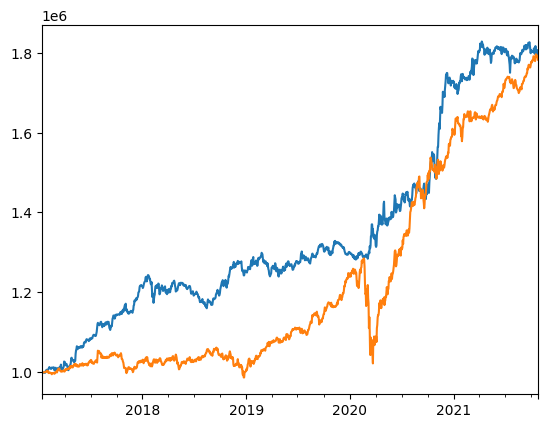

In [349]:
results.portfolio_value.plot()  
results2.portfolio_value.plot()

In [325]:
parameter_dict = tune_parameters(
    full_markowitz,
    prices_train,
    spread_train,
    volume_train,
    rf_train,
    0.1/np.sqrt(252),
)

SR: 1.3733613932003261
Iteration number 1; current sharpe: 1.3733613932003261
In a row: 1
Iteration number 2; current sharpe: 1.3733613932003261


KeyboardInterrupt: 

In [323]:
parameter_dict = tune_parameters(
    full_markowitz,
    prices_train,
    spread_train,
    volume_train,
    rf_train,
    0.1/np.sqrt(252),
)

SR: 0.020063744780476556
Iteration number 1; current sharpe: 0.020063744780476556


KeyboardInterrupt: 

In [317]:
for i in range(6):
    print(f"iteration {i}: {parameter_dict[i][1].sharpe}")



iteration 0: 1.1340514710076366


KeyError: 1

In [305]:
res = [*parameter_dict.values()][-1][1]
res.sharpe

0.461541717928363

In [199]:
len([*parameter_dict.values()])

2

In [196]:
params1 = [*parameter_dict.values()][1][0]

IndexError: list index out of range

In [192]:
params1

HyperParameters(gamma_hold=0, gamma_trade=0, gamma_turn=0, gamma_leverage=0, gamma_risk=0)

In [190]:
params

HyperParameters(gamma_hold=1, gamma_trade=1, gamma_turn=0.43961006880888853, gamma_leverage=0.10846804268846431, gamma_risk=5.309493434006647)

In [25]:
params = [*parameter_dict.values()][-1][0]
res = [*parameter_dict.values()][-1][1]

duals = parameter_dict["hard"][2]

/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

<Axes: >

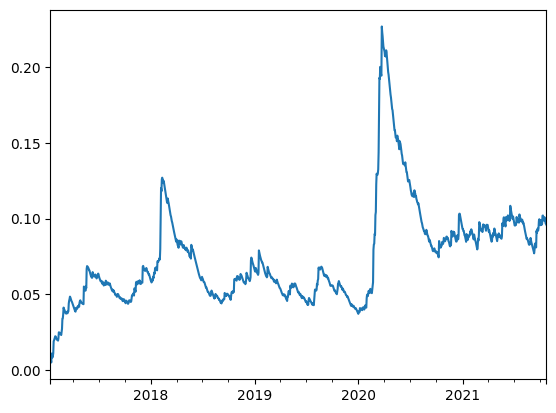

In [38]:
(res.portfolio_returns.ewm(halflife=21).std()*np.sqrt(252)).plot()

/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

<Axes: >

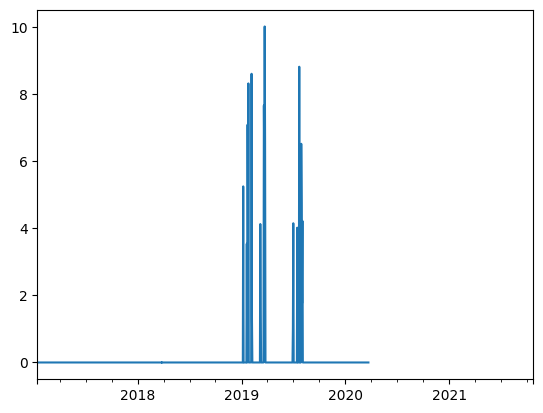

In [127]:
duals.Risk.plot()

In [207]:
duals.Risk.quantile(0.99)


7.291708678908718

In [244]:
hyperparameters

HyperParameters(gamma_hold=1, gamma_trade=1, gamma_turn=1, gamma_leverage=1, gamma_risk=1)

In [259]:
hyperparameters = HyperParameters(
    0, 0, 1, 1, 1
)

results, duals = run_markowitz(
            full_markowitz,
            prices,
            spread,
            volume,
            rf,
            0.1/np.sqrt(252),
            hyperparameters,
            verbose=True,
            hard=False,
        )

Day 500 of 6190, 2001-12-04 00:00:00
Day 600 of 6190, 2002-04-23 00:00:00
Day 700 of 6190, 2002-09-10 00:00:00
Day 800 of 6190, 2003-01-28 00:00:00
Day 900 of 6190, 2003-06-17 00:00:00
Day 1000 of 6190, 2003-11-04 00:00:00
Day 1100 of 6190, 2004-03-23 00:00:00
Day 1200 of 6190, 2004-08-10 00:00:00
Day 1300 of 6190, 2004-12-28 00:00:00
Day 1400 of 6190, 2005-05-17 00:00:00
Day 1500 of 6190, 2005-10-04 00:00:00
Day 1600 of 6190, 2006-02-21 00:00:00
Day 1700 of 6190, 2006-07-11 00:00:00
Day 1800 of 6190, 2006-11-28 00:00:00
Day 1900 of 6190, 2007-04-17 00:00:00
Day 2000 of 6190, 2007-09-04 00:00:00
Day 2100 of 6190, 2008-01-22 00:00:00
Day 2200 of 6190, 2008-06-10 00:00:00
Day 2300 of 6190, 2008-10-28 00:00:00
Day 2400 of 6190, 2009-03-17 00:00:00
Day 2500 of 6190, 2009-08-04 00:00:00
Day 2600 of 6190, 2009-12-22 00:00:00
Day 2700 of 6190, 2010-05-11 00:00:00
Day 2800 of 6190, 2010-09-28 00:00:00
Day 2900 of 6190, 2011-02-15 00:00:00
Day 3000 of 6190, 2011-07-05 00:00:00
Day 3100 of 6190,

/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

<Axes: >

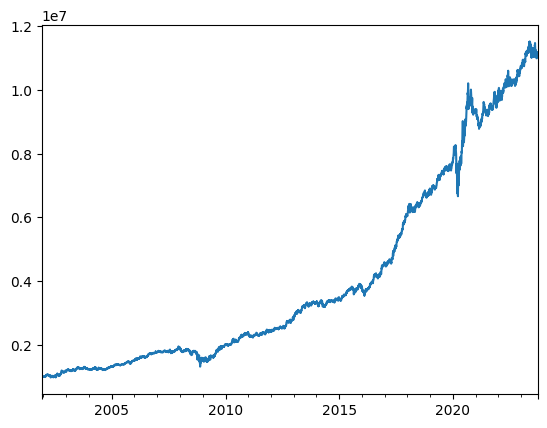

In [260]:
results.portfolio_value.plot()

In [265]:
results.max_drawdown    

-0.32638803873043054

/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

<Axes: >

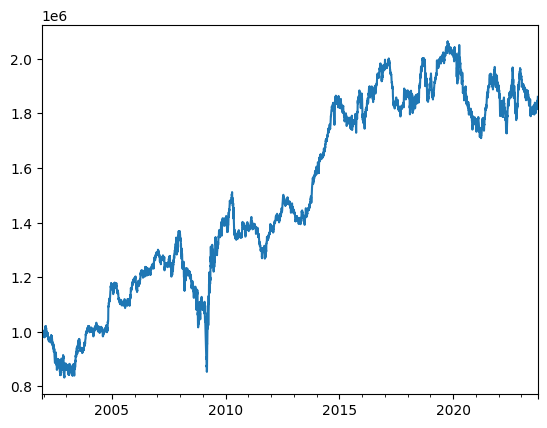

In [256]:
results.portfolio_value.plot()

/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

<Axes: >

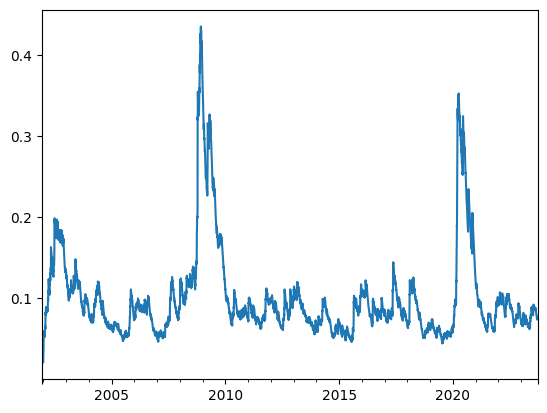

In [266]:
(results.portfolio_returns.ewm(halflife=21).std()*np.sqrt(252)).plot()

In [237]:
hyperparameters.copy()

AttributeError: 'HyperParameters' object has no attribute 'copy'

In [233]:
results.volatility

0.07567858373584031

In [230]:
duals.Risk.min()

26.399360132325086

In [164]:
results.volatility

0.08739814019039631

In [175]:
duals.Risk.quantile(0.95)

0.6879906219654076

/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

<Axes: >

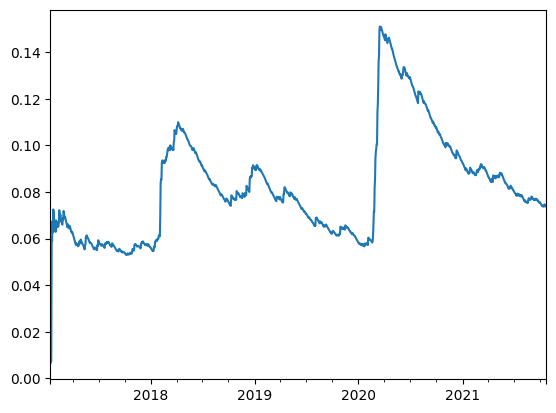

In [166]:
(results.portfolio_returns.ewm(halflife=63).std()*np.sqrt(252)).plot()

In [169]:
(results.portfolio_returns.ewm(halflife=63,min_periods=3).std()*np.sqrt(252)).dropna()

2017-01-16    0.007529
2017-01-17    0.060492
2017-01-18    0.059110
2017-01-19    0.067469
2017-01-20    0.062657
                ...   
2021-10-19    0.074412
2021-10-20    0.074055
2021-10-21    0.074080
2021-10-22    0.073719
2021-10-25    0.074138
Length: 1246, dtype: float64

In [45]:
duals

,FullInvestment,Cash,CLower,CUpper,WLower,WUpper,ZLower,ZUpper,Leverage,Turnover,Risk
2017-01-11,-0.022493,-0.022493,0.0,0.044987,"[8.645497121924764e-11, 8.64822986322676e-11, ...","[5.800290108533934e-11, 5.799849478351272e-11,...","[1.7353178972992174e-10, 1.7420510911588984e-1...","[1.7260021333071972e-10, 1.7196232545446157e-1...",0.0,0.130603,0.0
2017-01-12,-0.0,0.0,0.0,0.0,"[5.018588651634246e-12, 5.022938163623848e-12,...","[3.4946538881237427e-12, 3.4908557875011e-12, ...","[9.587590432590033e-12, 9.602293370062933e-12,...","[9.586888282691358e-12, 9.577822572341868e-12,...",0.0,0.203461,0.0
2017-01-13,0.0,-0.0,0.0,0.0,"[1.515752557183404e-11, 1.514591080735209e-11,...","[1.0449990100511559e-11, 1.0460508939054161e-1...","[2.97196472835524e-11, 2.9618176977133126e-11,...","[2.9427945501515436e-11, 2.95060877016097e-11,...",0.0,0.235401,0.0
2017-01-16,-0.0,0.0,0.0,0.0,"[6.367283836479898e-12, 6.368442563105979e-12,...","[4.3978822845228444e-12, 4.3990596182824394e-1...","[1.2449143416888898e-11, 1.2441485308561364e-1...","[1.2399102256135143e-11, 1.2402581819105919e-1...",0.0,0.176878,0.0
2017-01-17,-0.0,0.0,0.0,0.0,"[1.809540445246482e-12, 1.8071270123336188e-12...","[1.2979713187599259e-12, 1.2990121049300156e-1...","[3.4446674918545197e-12, 3.4424426740040523e-1...","[3.4214121539083812e-12, 3.4251743379707055e-1...",0.0,0.169632,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-10-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
results.volatility

0.08998748651468831

In [35]:
duals.Risk.dropna().median()

3.7107741831158124e-07

In [34]:
2.0178709772998465e-06

2.0178709772998465e-06

In [20]:
params

HyperParameters(gamma_hold=1, gamma_trade=0.5, gamma_turn=0.4139728480824029, gamma_leverage=0.06763282443730048, gamma_risk=2.0178709772998465e-06)

In [22]:
res.volatility

0.08413656506603158

In [95]:
res = [*parameter_dict.values()][-1][1]

In [94]:
res = [*parameter_dict.values()][-1][1]

HyperParameters(gamma_hold=1.5, gamma_trade=0.5, gamma_turn=0.8298874131078795, gamma_leverage=5.100934264218233e-09, gamma_risk=18.116732358099316)

In [70]:
results.sharpe

0.5040844840830921

In [62]:
risk_target = 0.1 / np.sqrt(252)
hyperparameters = HyperParameters(
    0, 0, 0, 0, 0
)

results, duals = run_markowitz(
    strategy,
    prices,
    spread,
    volume,
    rf,
    risk_target,
    hyperparameters,
    verbose=True,
) 

Day 500 of 6190, 2001-12-04 00:00:00
Day 600 of 6190, 2002-04-23 00:00:00
Day 700 of 6190, 2002-09-10 00:00:00
Day 800 of 6190, 2003-01-28 00:00:00


/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1395: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Day 900 of 6190, 2003-06-17 00:00:00
Day 1000 of 6190, 2003-11-04 00:00:00
Day 1100 of 6190, 2004-03-23 00:00:00
Day 1200 of 6190, 2004-08-10 00:00:00
Day 1300 of 6190, 2004-12-28 00:00:00
Day 1400 of 6190, 2005-05-17 00:00:00
Day 1500 of 6190, 2005-10-04 00:00:00
Day 1600 of 6190, 2006-02-21 00:00:00
Day 1700 of 6190, 2006-07-11 00:00:00
Day 1800 of 6190, 2006-11-28 00:00:00
Day 1900 of 6190, 2007-04-17 00:00:00
Day 2000 of 6190, 2007-09-04 00:00:00
Day 2100 of 6190, 2008-01-22 00:00:00
Day 2200 of 6190, 2008-06-10 00:00:00
Day 2300 of 6190, 2008-10-28 00:00:00
Day 2400 of 6190, 2009-03-17 00:00:00
Day 2500 of 6190, 2009-08-04 00:00:00
Day 2600 of 6190, 2009-12-22 00:00:00
Day 2700 of 6190, 2010-05-11 00:00:00
Day 2800 of 6190, 2010-09-28 00:00:00
Day 2900 of 6190, 2011-02-15 00:00:00
Day 3000 of 6190, 2011-07-05 00:00:00
Day 3100 of 6190, 2011-11-22 00:00:00
Day 3200 of 6190, 2012-04-10 00:00:00
Day 3300 of 6190, 2012-08-28 00:00:00
Day 3400 of 6190, 2013-01-15 00:00:00
Day 3500 of 6

In [63]:
print(f"mean: {results.mean_return}")
print(f"volatility: {results.volatility}")
print(f"max drawdown: {results.max_drawdown}")
print(f"max leverage: {results.max_leverage}")
print(f"sharpe: {results.sharpe}")
print(f"turnover: {results.turnover}")

mean: 0.04523447537467463
volatility: 0.08973590103046751
max drawdown: -0.2965556038964159
max leverage: 2.504314108737476
sharpe: 0.5040844840830921
turnover: 12.89692623810611


/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

<Axes: >

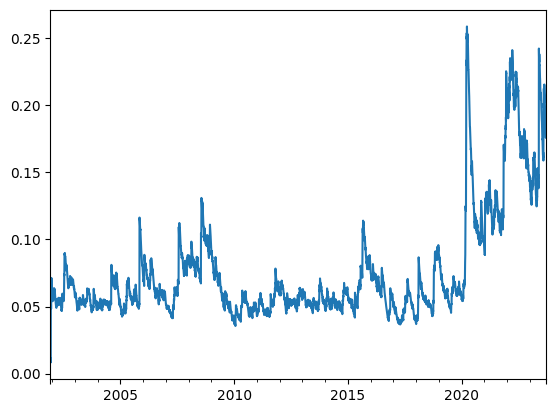

In [64]:
(results.portfolio_returns.ewm(halflife=21).std()*np.sqrt(252)).plot()

In [18]:
cons[0].name

'long_only'

In [3]:
t = returns.index[0]

prices_t = prices.loc[t]
returns_t = returns.loc[t]
spread_t = spread.loc[t]
volume_t = volume.loc[t]
rf_t = rf.loc[t]

Sigma_t = returns.cov()
mu_t = returns.mean()

risk_target = 0.1 / np.sqrt(252) 
T_max = 10 / 252
# T_max = 1

L_max = 1.6

In [4]:
def get_data_and_parameters(inputs, risk_target, T_max, L_max):

    n_assets = inputs.n_assets
    latest_prices = inputs.prices.iloc[-1]
    portfolio_value = inputs.cash + inputs.quantities @ latest_prices

    data = Data(
        w_prev=(inputs.quantities * latest_prices / portfolio_value),
        c_prev=(inputs.cash / portfolio_value),
        idio_mean=np.zeros(n_assets),
        factor_mean=inputs.mean.values,
        risk_free=0,
        factor_covariance_chol=np.linalg.cholesky(inputs.covariance.values),
        idio_volas=np.zeros(n_assets),
        F=np.eye(n_assets),
        kappa_short=np.zeros(n_assets),
        kappa_borrow=0.0,
        kappa_spread=np.zeros(n_assets),
        kappa_impact=np.zeros(n_assets),
    )

    param = Parameters(
        w_lower=-0.1,
        w_upper=0.15,
        c_lower=-0.3,
        c_upper=0.4,
        z_lower=-np.ones(data.n_assets) * 1e3,
        z_upper=np.ones(data.n_assets) * 1e3,
        T_max=T_max,
        L_max=L_max,
        rho_mean=np.zeros(data.n_assets),
        rho_covariance=0.0,
        gamma_hold=0.0,
        gamma_trade=0.0,
        gamma_turn=0.0,
        gamma_risk=0,
        risk_target=risk_target,
        gamma_c_lower=None,
        gamma_c_upper=None,
        gamma_w_lower=None,
        gamma_w_upper=None,
        gamma_z_lower=None,
        gamma_z_upper=None,
        gamma_L_max=None,
    )

    return data, param

def get_data_and_parameters2(inputs, gamma_risk, gamma_turn, gamma_c_lower, gamma_c_upper, gamma_w_lower, gamma_w_upper, gamma_z_lower, gamma_z_upper, gamma_L_max, risk_target, T_max, L_max=1.6):
                             
    n_assets = inputs.n_assets
    latest_prices = inputs.prices.iloc[-1]
    portfolio_value = inputs.cash + inputs.quantities @ latest_prices

    data = Data(
        w_prev=(inputs.quantities * latest_prices / portfolio_value),
        c_prev=(inputs.cash / portfolio_value),
        idio_mean=np.zeros(n_assets),
        factor_mean=inputs.mean.values,
        risk_free=0,
        factor_covariance_chol=np.linalg.cholesky(inputs.covariance.values),
        idio_volas=np.zeros(n_assets),
        F=np.eye(n_assets),
        kappa_short=np.zeros(n_assets),
        kappa_borrow=0.0,
        kappa_spread=np.zeros(n_assets),
        kappa_impact=np.zeros(n_assets),
    )

    # param = Parameters(
    #     w_lower=-0.1,
    #     w_upper=0.15,
    #     c_lower=-0.3,
    #     c_upper=0.4,
    #     z_lower=-np.ones(data.n_assets) * 1e3,
    #     z_upper=np.ones(data.n_assets) * 1e3,
    #     T_max=0,
    #     L_max=L_max,
    #     rho_mean=np.zeros(data.n_assets),
    #     rho_covariance=0.0,
    #     gamma_hold=0.0,
    #     gamma_trade=0.0,
    #     gamma_turn=gamma_turn,
    #     gamma_risk=gamma_risk,
    #     risk_target=inputs.risk_target,
    # )

    param = Parameters(
        w_lower=-0.1,
        w_upper=0.15,
        c_lower=-0.3,
        c_upper=0.4,
        z_lower=-np.ones(data.n_assets) * 1e3,
        z_upper=np.ones(data.n_assets) * 1e3,
        T_max=T_max,
        L_max=L_max,
        rho_mean=np.zeros(data.n_assets),
        rho_covariance=0.0,
        gamma_hold=0.0,
        gamma_trade=0.0,
        gamma_turn=gamma_turn,
        gamma_risk=gamma_risk,
        risk_target=inputs.risk_target,
        gamma_c_lower=gamma_c_lower,
        gamma_c_upper=gamma_c_upper,
        gamma_w_lower=gamma_w_lower,
        gamma_w_upper=gamma_w_upper,
        gamma_z_lower=gamma_z_lower,
        gamma_z_upper=gamma_z_upper,
        gamma_L_max=gamma_L_max,
    )

    

    return data, param


    

In [18]:
import time
import cvxpy as cp
def run_markowitz(
    # strategy: Callable, risk_target: float, verbose: bool = False,
    prices, spread, volume, rf, hard=True, verbose: bool = False,
) -> tuple[pd.Series, pd.DataFrame]:
    """
    Run a simplified backtest for a given strategy.
    At time t we use data from t-lookback to t to compute the optimal portfolio
    weights and then execute the trades at time t.
    """

    # prices, spread, volume, rf = load_data()
    n_assets = prices.shape[1]

    lookback = 500

    # Initialize quantities as equally weighted fully invested portfolio
    prices0 = prices.iloc[lookback]
    quantities = np.ones(n_assets) * (1 / prices0) / np.sum(1 / prices0)
    cash = 0

    post_trade_cash = []
    post_trade_quantities = []

    if hard:
        dual_optimals = pd.DataFrame(columns=["Risk", "Turnover", "CLower", "CUpper", "WUpper", "WLower", "ZUpper", "ZLower", "Leverage"], index=prices.index[lookback:-1])
    
    timings = []

    returns = prices.pct_change().dropna() 
    means = (
        synthetic_returns(prices, information_ratio=0.07).shift(-1).dropna()
    )  # At time t includes data up to t+1
    covariance_df = returns.ewm(halflife=125).cov()  # At time t includes data up to t
    days = returns.index
    covariances = {}
    for day in days:
        covariances[day] = covariance_df.loc[day]

    for t in range(lookback, len(prices) - 1):
        start_time = time.perf_counter()

        day = prices.index[t]

        if verbose and t%100 == 0:
            print(f"Day {t} of {len(prices)-1}, {day}")

        prices_t = prices.iloc[t - lookback : t + 1]  # Up to t
        spread_t = spread.iloc[t - lookback : t + 1]
        volume_t = volume.iloc[t - lookback : t + 1]

        mean_t = means.loc[day]  # Forecast for return t to t+1
        covariance_t = covariances[day]  # Forecast for covariance t to t+1

        inputs_t = OptimizationInput(
            prices_t,
            mean_t,
            covariance_t,
            spread_t,
            volume_t,
            quantities,
            cash,
            risk_target,
            rf.iloc[t],
        )

        data, param = get_data_and_parameters(inputs_t, risk_target, T_max, L_max)

        success = True
        try:
            w, _, problem = markowitz_hard(data, param)
        except (AssertionError, cp.SolverError) as e:
            print("Failed: removing T_max")
            data, param = get_data_and_parameters(inputs_t, risk_target, T_max=1e3, L_max=L_max)
            try :
                success = False
                w, _, problem = markowitz_hard(data, param)
            except (AssertionError, cp.SolverError) as f:
                print("Failed: removing L_max")
                # data, param = get_data_and_parameters(inputs_t, risk_target, T_max=1, L_max=3)
                # w, _, problem = markowitz_hard(data, param)


            

        latest_prices = prices.iloc[t]  # At t
        latest_spread = spread.iloc[t]

        cash += interest_and_fees(
            cash, rf.iloc[t - 1], quantities, prices.iloc[t - 1], day
        )
        trade_quantities = create_orders(w, quantities, cash, latest_prices)
        quantities += trade_quantities
        cash += execute_orders(latest_prices, trade_quantities, latest_spread)

        post_trade_cash.append(cash)
        post_trade_quantities.append(quantities.copy())
        dual_optimals.loc[day, "CLower"] = problem.constraints[2].dual_value
        dual_optimals.loc[day, "CUpper"] = problem.constraints[3].dual_value
        dual_optimals.loc[day, "WLower"] = problem.constraints[4].dual_value
        dual_optimals.loc[day, "WUpper"] = problem.constraints[5].dual_value
        dual_optimals.loc[day, "ZLower"] = problem.constraints[6].dual_value
        dual_optimals.loc[day, "ZUpper"] = problem.constraints[7].dual_value
        dual_optimals.loc[day, "Leverage"] = problem.constraints[8].dual_value
        if success:
            dual_optimals.loc[day, "Turnover"] = problem.constraints[9].dual_value
        else:
            try:
                dual_optimals.loc[day, "Turnover"] = dual_optimals.loc[prices.index[t-1], "Turnover"]
            except KeyError:
                dual_optimals.loc[day, "Turnover"] = problem.constraints[9].dual_value
        success = True
        dual_optimals.loc[day, "Risk"] = problem.constraints[10].dual_value

        # dual_optimals.append(problem.constraints[-1].dual_value)

        # Timings
        end_time = time.perf_counter()
        timings.append(Timing.get_timing(start_time, end_time, problem))

    post_trade_cash = pd.Series(post_trade_cash, index=prices.index[lookback:-1])
    post_trade_quantities = pd.DataFrame(
        post_trade_quantities, index=prices.index[lookback:-1], columns=prices.columns
    )

    return BacktestResult(post_trade_cash, post_trade_quantities, risk_target, timings), dual_optimals

####################
def run_soft_markowitz(
    prices, spread, volume, rf, priorities, verbose: bool = False,
) -> tuple[pd.Series, pd.DataFrame]:
    """
    Run a simplified backtest for a given strategy.
    At time t we use data from t-lookback to t to compute the optimal portfolio
    weights and then execute the trades at time t.
    """

    # prices, spread, volume, rf = load_data()
    n_assets = prices.shape[1]

    lookback = 500
    
    prices0 = prices.iloc[lookback]
    quantities = np.ones(n_assets) * (1 / prices0) / np.sum(1 / prices0)
    cash = 0

    post_trade_cash = []
    post_trade_quantities = []
    timings = []
    risks = pd.Series(index=prices.index[lookback:-1])
    turnovers = pd.Series(index=prices.index[lookback:-1])

    returns = prices.pct_change().dropna() 
    means = (
        synthetic_returns(prices, information_ratio=0.07).shift(-1).dropna()
    )  # At time t includes data up to t+1
    covariance_df = returns.ewm(halflife=125).cov()  # At time t includes data up to t
    days = returns.index
    covariances = {}
    for day in days:
        covariances[day] = covariance_df.loc[day]

    for t in range(lookback, len(prices) - 1):
        start_time = time.perf_counter()

        day = prices.index[t]

        if verbose and t%100 == 0:
            print(f"Day {t} of {len(prices)-1}, {day}")

        prices_t = prices.iloc[t - lookback : t + 1]  # Up to t
        spread_t = spread.iloc[t - lookback : t + 1]
        volume_t = volume.iloc[t - lookback : t + 1]

        mean_t = means.loc[day]  # Forecast for return t to t+1
        covariance_t = covariances[day]  # Forecast for covariance t to t+1

        inputs_t = OptimizationInput(
            prices_t,
            mean_t,
            covariance_t,
            spread_t,
            volume_t,
            quantities,
            cash,
            risk_target,
            rf.iloc[t],
        )

        gamma_risk=priorities.loc[day].Risk
        gamma_turn=priorities.loc[day].Turnover
        gamma_c_lower=priorities.loc[day].CLower
        gamma_c_upper=priorities.loc[day].CUpper
        gamma_w_lower=priorities.loc[day].WLower
        gamma_w_upper=priorities.loc[day].WUpper
        gamma_z_lower=priorities.loc[day].ZLower
        gamma_z_upper=priorities.loc[day].ZUpper
        gamma_L_max=priorities.loc[day].Leverage


        data, param = get_data_and_parameters2(inputs_t, 
                                               gamma_risk=gamma_risk, gamma_turn=gamma_turn, gamma_c_lower=gamma_c_lower, gamma_c_upper=gamma_c_upper, gamma_w_lower=gamma_w_lower, gamma_w_upper=gamma_w_upper, gamma_z_lower=gamma_z_lower, gamma_z_upper=gamma_z_upper, gamma_L_max=gamma_L_max, risk_target=risk_target, T_max=T_max, L_max=L_max)

        w, _, problem = markowitz(data, param)

        latest_prices = prices.iloc[t]  # At t
        latest_spread = spread.iloc[t]

        cash += interest_and_fees(
            cash, rf.iloc[t - 1], quantities, prices.iloc[t - 1], day
        )
        trade_quantities = create_orders(w, quantities, cash, latest_prices)
        quantities += trade_quantities
        cash += execute_orders(latest_prices, trade_quantities, latest_spread)

        post_trade_cash.append(cash)
        post_trade_quantities.append(quantities.copy())

        risk = np.sqrt(np.dot(np.dot(w, covariance_t), w)) * np.sqrt(252)
        turnover = np.sum(np.abs(w - data.w_prev))
        risks.loc[day] = risk
        turnovers.loc[day] = turnover

        # Timings
        end_time = time.perf_counter()
        timings.append(Timing.get_timing(start_time, end_time, problem))

    post_trade_cash = pd.Series(post_trade_cash, index=prices.index[lookback:-1])
    post_trade_quantities = pd.DataFrame(
        post_trade_quantities, index=prices.index[lookback:-1], columns=prices.columns
    )

    return BacktestResult(post_trade_cash, post_trade_quantities, risk_target, timings), risks, turnovers

In [19]:
results, duals = run_backtest(
    # strategy: Callable, risk_target: float, verbose: bool = False,
    prices, spread, volume, rf, True,
)

Day 500 of 6190, 2001-12-04 00:00:00
Failed: removing T_max
Day 600 of 6190, 2002-04-23 00:00:00
Failed: removing T_max
Day 700 of 6190, 2002-09-10 00:00:00
Failed: removing T_max
Failed: removing T_max
Day 800 of 6190, 2003-01-28 00:00:00
Failed: removing T_max
Failed: removing T_max
Day 900 of 6190, 2003-06-17 00:00:00
Day 1000 of 6190, 2003-11-04 00:00:00
Day 1100 of 6190, 2004-03-23 00:00:00
Day 1200 of 6190, 2004-08-10 00:00:00
Day 1300 of 6190, 2004-12-28 00:00:00
Day 1400 of 6190, 2005-05-17 00:00:00
Day 1500 of 6190, 2005-10-04 00:00:00
Day 1600 of 6190, 2006-02-21 00:00:00
Day 1700 of 6190, 2006-07-11 00:00:00
Day 1800 of 6190, 2006-11-28 00:00:00
Day 1900 of 6190, 2007-04-17 00:00:00
Day 2000 of 6190, 2007-09-04 00:00:00
Day 2100 of 6190, 2008-01-22 00:00:00
Failed: removing T_max
Failed: removing T_max
Day 2200 of 6190, 2008-06-10 00:00:00
Failed: removing T_max
Failed: removing T_max
Failed: removing T_max
Failed: removing T_max
Failed: removing T_max
Day 2300 of 6190, 2008

In [33]:
10/252 * 252

10.0

In [35]:
print(f"mean: {results.portfolio_returns.mean() * 252}")
print(f"volatility: {results.portfolio_returns.std() * np.sqrt(252)}")
print(f"max drawdown: {results.max_drawdown}")
print(f"max leverage: {results.max_leverage}")
print(f"sharpe: {results.sharpe}")
print(f"turnover: {results.turnover}")

mean: 0.09888883284649798
volatility: 0.10021556428044409
max drawdown: -0.21454040398029073
max leverage: 1.610985064846046
sharpe: 1.004084261845295
turnover: 18.549502794487584


In [69]:
print(f"mean: {results2.portfolio_returns.mean() * 252}")
print(f"volatility: {results2.portfolio_returns.std() * np.sqrt(252)}")
print(f"max drawdown: {results2.max_drawdown}")
print(f"max leverage: {results2.max_leverage}")
print(f"sharpe: {results2.sharpe}")
print(f"turnover: {results2.turnover}")

mean: 0.11898647918073932
volatility: 0.13668691122539112
max drawdown: -0.2630880870121153
max leverage: 1.9235078483587063
sharpe: 0.8857859130483625
turnover: 16.61892990122609


In [77]:
(4-2*np.sqrt(3))**2

0.2871870788979635

In [83]:
-72/38 + 20*(1-(37/38)**36) - 20 * (37/38)**36

2.790419081085642

In [76]:
print(f"mean: {results2.portfolio_returns.mean() * 252}")
print(f"volatility: {results2.portfolio_returns.std() * np.sqrt(252)}")
print(f"max drawdown: {results2.max_drawdown}")
print(f"max leverage: {results2.max_leverage}")
print(f"sharpe: {results2.sharpe}")
print(f"turnover: {results2.turnover}")

mean: 0.09231373957817875
volatility: 0.10606003538819855
max drawdown: -0.25982737580283366
max leverage: 2.3699631307778994
sharpe: 0.8856714835842171
turnover: 18.785408351372173


/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

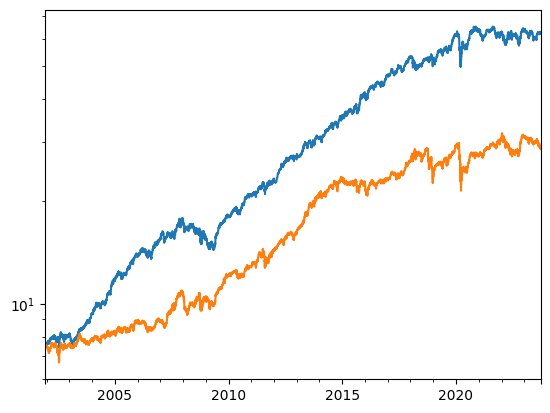

In [73]:
results.portfolio_value.plot()
results2.portfolio_value.plot()

plt.yscale("log")

In [13]:
print(f"mean: {results2.portfolio_returns.mean() * 252}")
print(f"volatility: {results2.portfolio_returns.std() * np.sqrt(252)}")
print(f"max drawdown: {results2.max_drawdown}")
print(f"max leverage: {results2.max_leverage}")
print(f"sharpe: {results2.sharpe}")

mean: 0.10672537668119053
volatility: 0.11644357518590612
max drawdown: -0.19847506847099672
max leverage: 2.983746552565785
sharpe: 0.9326318657509529


In [29]:
results2.portfolio_returns

/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/experiments/backtest.py:224: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  return self.portfolio_value.pct_change().dropna()


Series([], dtype: float64)

In [62]:
# create dataframe where rows are duals.WUpper
Wupper = pd.DataFrame([duals.WUpper.values[i] for i in range(duals.shape[0])])
Wupper.index = duals.index
Wupper = Wupper.rolling(100, min_periods=1).quantile(0.8)
WLower = pd.DataFrame([duals.WLower.values[i] for i in range(duals.shape[0])])
WLower.index = duals.index
WLower = WLower.rolling(100, min_periods=1).quantile(0.8)

Zupper = pd.DataFrame([duals.ZUpper.values[i] for i in range(duals.shape[0])])
Zupper.index = duals.index
Zupper = Zupper.rolling(100, min_periods=1).quantile(0.8)
ZLower = pd.DataFrame([duals.ZLower.values[i] for i in range(duals.shape[0])])
ZLower.index = duals.index
ZLower = ZLower.rolling(100, min_periods=1).quantile(0.8)

In [74]:
priorities = pd.DataFrame(index = duals.index, columns=duals.columns)

for t in priorities.index:
    priorities.loc[t]["WUpper"] = Wupper.loc[t].values
    priorities.loc[t]["WLower"] = WLower.loc[t].values
    priorities.loc[t]["ZUpper"] = Zupper.loc[t].values * 0
    priorities.loc[t]["ZLower"] = ZLower.loc[t].values * 0

columns_remaining = ["Risk", "CLower", "CUpper"]
priorities[columns_remaining] = duals[columns_remaining].rolling(100, min_periods=1).quantile(0.99) 

priorities["Leverage"] = duals["Leverage"].rolling(100, min_periods=1).quantile(0.9)
priorities["Turnover"] = duals["Turnover"].rolling(100, min_periods=1).quantile(0.8)

In [18]:
0.00111194306017219 * 1000

1.11194306017219

In [75]:
results2, risks, turnovers = run_backtest2(
    # strategy: Callable, risk_target: float, verbose: bool = False,
    prices, spread, volume, rf, priorities.abs(), True
)

Day 500 of 6190, 2001-12-04 00:00:00
Day 600 of 6190, 2002-04-23 00:00:00
Day 700 of 6190, 2002-09-10 00:00:00
Day 800 of 6190, 2003-01-28 00:00:00
Day 900 of 6190, 2003-06-17 00:00:00
Day 1000 of 6190, 2003-11-04 00:00:00
Day 1100 of 6190, 2004-03-23 00:00:00
Day 1200 of 6190, 2004-08-10 00:00:00
Day 1300 of 6190, 2004-12-28 00:00:00
Day 1400 of 6190, 2005-05-17 00:00:00
Day 1500 of 6190, 2005-10-04 00:00:00
Day 1600 of 6190, 2006-02-21 00:00:00
Day 1700 of 6190, 2006-07-11 00:00:00
Day 1800 of 6190, 2006-11-28 00:00:00
Day 1900 of 6190, 2007-04-17 00:00:00
Day 2000 of 6190, 2007-09-04 00:00:00
Day 2100 of 6190, 2008-01-22 00:00:00
Day 2200 of 6190, 2008-06-10 00:00:00
Day 2300 of 6190, 2008-10-28 00:00:00
Day 2400 of 6190, 2009-03-17 00:00:00
Day 2500 of 6190, 2009-08-04 00:00:00
Day 2600 of 6190, 2009-12-22 00:00:00
Day 2700 of 6190, 2010-05-11 00:00:00
Day 2800 of 6190, 2010-09-28 00:00:00
Day 2900 of 6190, 2011-02-15 00:00:00
Day 3000 of 6190, 2011-07-05 00:00:00
Day 3100 of 6190,

In [68]:
returns

,T0,T1,T3,T4,T5,T6,T7,T8,T9,T10,...,T89,T90,T92,T93,T94,T95,T96,T98,T99,T100
2000-01-05,-0.025398,0.046893,0.060678,0.029942,-0.004416,0.026336,0.021299,0.041501,-0.018286,0.051260,...,0.019823,-0.003551,0.008401,0.020228,0.061013,0.054994,0.003040,-0.023089,0.057692,-0.003393
2000-01-06,0.021220,-0.010311,0.010249,0.044252,0.015084,0.041056,0.001100,-0.030361,0.045847,0.057275,...,0.029155,-0.003563,0.024993,0.026399,0.039316,-0.067926,0.017840,0.045790,-0.005188,0.044150
2000-01-07,0.013300,-0.003173,0.029033,0.032688,0.017481,0.016898,0.063595,-0.023483,-0.010956,-0.005125,...,0.073653,0.023816,0.043161,-0.023890,0.111840,0.020334,0.002893,0.028248,0.000000,0.017886
2000-01-10,0.014358,-0.005315,-0.014089,-0.032829,-0.017181,-0.026313,-0.029896,0.152305,-0.002769,-0.013982,...,-0.039578,0.030227,0.010344,0.009426,-0.004435,-0.003316,-0.040808,-0.012361,0.016973,-0.028758
2000-01-11,0.009299,-0.014956,-0.014326,-0.015756,-0.023602,-0.009245,0.034007,0.010434,-0.001394,0.011941,...,0.003662,-0.027083,-0.002526,-0.008410,0.005941,0.004999,-0.033434,-0.031988,0.050069,-0.019736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-20,-0.013304,0.005988,-0.010319,-0.003790,-0.004230,-0.003050,0.004469,0.007567,-0.016158,-0.007926,...,-0.009253,-0.011908,-0.004376,-0.002342,-0.013918,-0.008057,0.003856,-0.011112,-0.006130,-0.008098
2023-09-21,-0.016027,-0.009226,-0.011958,-0.023617,-0.007822,-0.008999,-0.015400,0.002059,-0.017331,-0.014089,...,-0.034250,-0.020008,-0.018636,-0.014019,-0.004085,0.006722,-0.022040,-0.016209,-0.026053,-0.012829
2023-09-22,-0.010536,-0.000300,-0.011203,0.003786,-0.009583,0.006598,0.001043,-0.017890,0.000756,0.001568,...,0.000745,-0.000570,0.000358,-0.010616,-0.002361,-0.010294,-0.009316,-0.006671,-0.008079,-0.025756
2023-09-25,0.000980,-0.003606,0.005412,0.004431,0.004941,0.014614,-0.010417,-0.002954,0.016029,0.011223,...,0.003179,0.009549,0.004029,0.003446,-0.003737,0.019958,-0.001813,-0.003969,-0.002752,0.008004


/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

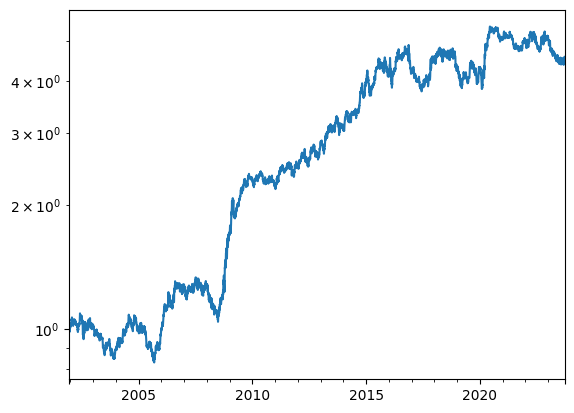

In [126]:
(results2.portfolio_value/results.portfolio_value).plot()
plt.yscale("log")

/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

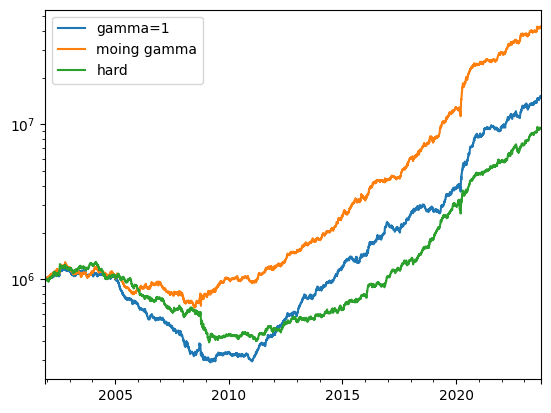

In [133]:
results3.portfolio_value.plot(label="gamma=1")
results2.portfolio_value.plot(label="moing gamma")
results.portfolio_value.plot(label="hard")
plt.legend()
plt.yscale("log")

/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

<Axes: >

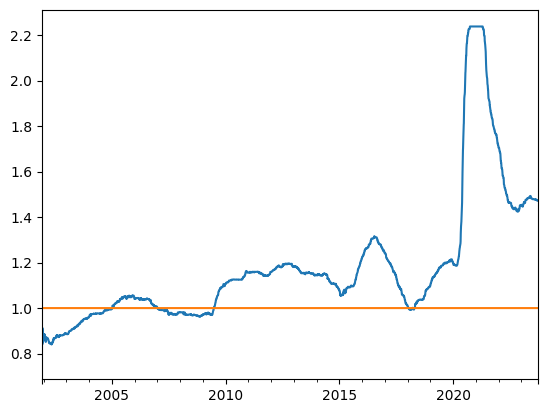

In [135]:
gamma_risks.plot()
gamma_risks3.plot()


In [122]:
(np.array(risks) <= 0.10).mean()

0.7769771528998243

In [116]:
print(f"mean: {results2.portfolio_returns.mean() * 252}")
print(f"volatility: {results2.portfolio_returns.std() * np.sqrt(252)}")
print(f"max drawdown: {results2.max_drawdown}")
print(f"max leverage: {results2.max_leverage}")
print(f"sharpe: {results2.sharpe}")

mean: 0.17344025387119444
volatility: 0.12064983093961906
max drawdown: -0.49037035995050804
max leverage: 7.550241878147584
sharpe: 1.4627875923226943


In [128]:
print(f"mean: {results3.portfolio_returns.mean() * 252}")
print(f"volatility: {results3.portfolio_returns.std() * np.sqrt(252)}")
print(f"max drawdown: {results3.max_drawdown}")
print(f"max leverage: {results3.max_leverage}")
print(f"sharpe: {results3.sharpe}")

mean: 0.12792709614439182
volatility: 0.12783809076710367
max drawdown: -0.756279240047702
max leverage: 7.62225670231688
sharpe: 1.0182639087089391


In [117]:
print(f"mean: {results.portfolio_returns.mean() * 252}")
print(f"volatility: {results.portfolio_returns.std() * np.sqrt(252)}")
print(f"max drawdown: {results.max_drawdown}")
print(f"max leverage: {results.max_leverage}")
print(f"sharpe: {results.sharpe}")

mean: 0.10690152368482325
volatility: 0.1249899715015102
max drawdown: -0.6974539553309929
max leverage: 7.222564873298741
sharpe: 0.8702956470609065


In [ ]:
results2

In [98]:
results.volatility

0.1271842267963638

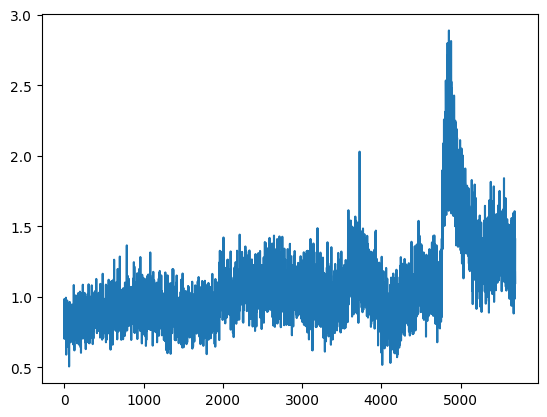

In [47]:
plt.plot(duals)